In [3]:
!pip install awswrangler

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached awswrangler-2.18.0-py3-none-any.whl (255 kB)
  Using cached pg8000-1.29.3-py3-none-any.whl (51 kB)
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached redshift_connector-2.0.909-py3-none-any.whl (112 kB)
  Using cached requests_aws4auth-1.1.2-py2.py3-none-any.whl (24 kB)
  Using cached jsonpath_ng-1.5.3-py3-none-any.whl (29 kB)
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached opensearch_py-2.0.1-py2.py3-none-any.whl (214 kB)
  Using cached gremlinpython-3.6.1-py2.py3-none-any.whl (73 kB)
  Using cached aiohttp-3.8.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached aenum-3.1.11-py3-none-any.whl (131 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached scramp-1.4.4-py3-none-any.whl (13 kB)
  Using cached python_utils-3.4.5

In [4]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from tqdm import tqdm 

role = get_execution_role()
s3 = boto3.resource('s3')

In [24]:
def plot_time_distr(tot, title):
    m0 = tot[tot.time>=0]
    n_days = 2
    f, ax = plt.subplots()
    b = np.linspace(0,n_days*24*60,100)
    ax = m0.groupby('a_patientid').time.min().hist(bins=b, ax=ax)
    _ = ax.set_title(title)
    _ = ax.set_xticks([i*60*6 for i in range(n_days*4)])
    _ = ax.set_xticklabels([i*6 for i in range(n_days*4)])
    _ = ax.set_xlabel('Time [hours]')
    return f, ax

In [5]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [6]:
variables = wr.s3.read_parquet(path="s3://icusics-db/d_variables/d_variables.parquet")
variables_h4 = variables[variables.hospital_coded==4]
diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h4.parquet")
labresults_numeric = wr.s3.read_parquet(path="s3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet")

# Check for predictors variable_id

Predictors:
 - Albumine
 - Potassium
 - SpO2
 - Haematocrit
 - Ph
 - Blood Urine Nitrate / Urea * 0.357

Outcome:
 - CRRT

In [11]:
time_window = 24 * 60

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


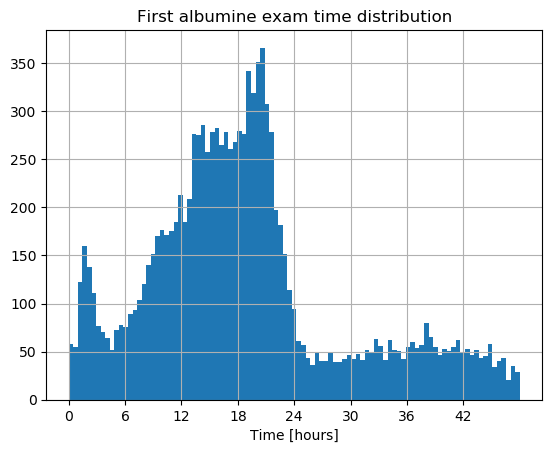

In [107]:
# Albumine

alb_idx = [
    1024000512,2024000340,3024001802,
    4024002341,5024001802,6024002862
]

albumine = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(alb_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    if i == 1:
        ith.loc[:,'value'] = ith.loc[:,'value'] / 10
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    albumine.append(ith)
    
albumine = pd.concat(albumine)
albumine.columns = ['albumine_min','albumine_max']
#albumine.to_csv('./tmp/tmp_table.csv')
#albumine = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First albumine exam time distribution')
plt.show()

100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


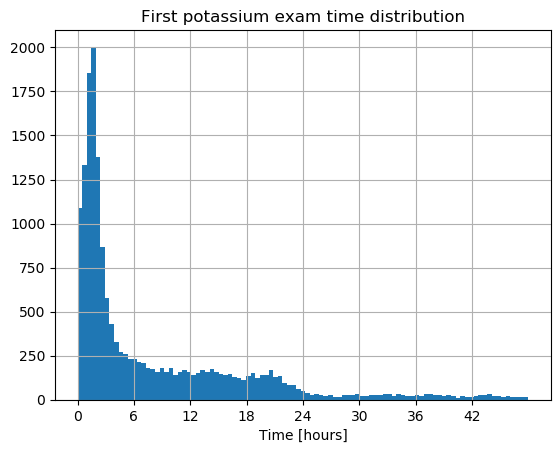

In [122]:
# Potassium

potassium_idx = [
    1020000500,2020000500,3020000500,
    4020000500,5020000500,6020000500
]

potassium = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(potassium_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    potassium.append(ith)
    
potassium = pd.concat(potassium)
potassium.columns = ['potassium_min','potassium_max']
potassium.to_csv('./tmp/tmp_table.csv')
potassium = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First potassium exam time distribution')
plt.show()

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


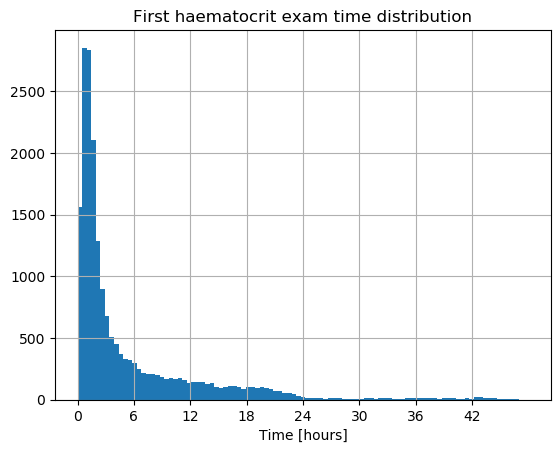

In [109]:
# Haematocrit

haema_idx = [
    1020000100,2020000100,3020000100,
    4020000100,5020000100,6020000100
]

haematocrit = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(haema_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    haematocrit.append(ith)
    
haematocrit = pd.concat(haematocrit)
haematocrit.columns = ['haematocrit_min','haematocrit_max']
#haematocrit.to_csv('./tmp/tmp_table.csv')
#haematocrit = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First haematocrit exam time distribution')
plt.show()

100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


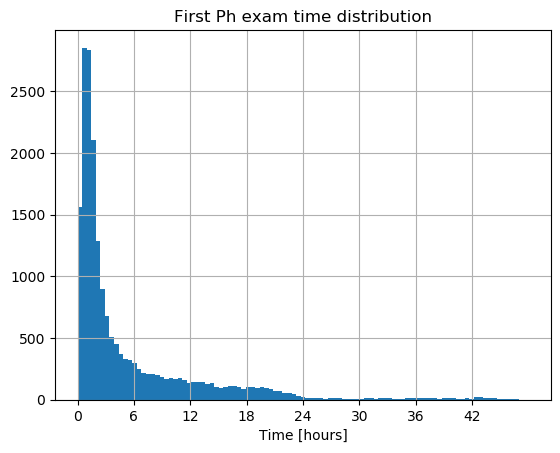

In [110]:
# Ph

ph_idx = [
    1020000100,2020000100,3020000100,
    4020000100,5020000100,6020000100
]

ph = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(ph_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    ph.append(ith)
    
ph = pd.concat(ph)
ph.columns = ['ph_min','ph_max']
#ph.to_csv('./tmp/tmp_table.csv')
#ph = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First Ph exam time distribution')
plt.show()

100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


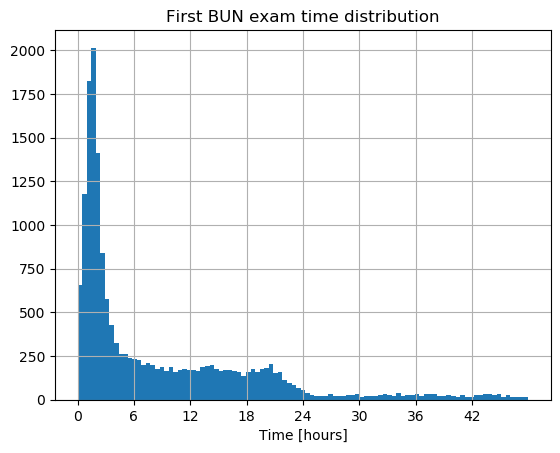

In [112]:
# Blood Urine Nitrate
# urea * 0.357

bun_idx = [
    1020004100,2020004100,3020004100,
    4020004100,5024001806,5020004100,
    6020004100
]

bun = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(bun_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    bun.append(ith)
    
bun = pd.concat(bun)
bun.columns = ['bun_min','bun_max']
#bun_idx.to_csv('./tmp/tmp_table.csv')
#bun_idx = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First BUN exam time distribution')
plt.show()

In [114]:
# SpO2

idx = [
    1000004000,2000004000,3000004000,
    4000004000,5000004000,6000004000, # SpO2
]

crrt_idx = [
    1000001380,1000005666, # Flux
    2000001380,2000005666,
    3000001380,3000005666,
    4000001380,4000005666,
    5000001380,5000005666,
    6000001380,6000005666
]

spo2 = []
crrt = []
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0].values):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    
    ith = ith_monitored[ith_monitored.a_variableid.isin(idx)]
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    spo2.append(ith)
    
    #crrt_ith = ith_monitored[ith_monitored.a_variableid.isin(crrt_idx)]
    #crrt_ith_grp = crrt_ith.groupby(['a_patientid','a_variableid']).time.min()
    #crrt.append(crrt_ith_grp)



spo2 = pd.concat(spo2)
spo2.columns = ['spo2_min','spo2_max']
#crrt = pd.concat(crrt)

#spo2.to_csv('./tmp/tmp_table.csv')
#spo2 = pd.read_csv('./tmp/tmp_table.csv', index_col=0)


100%|██████████| 600/600 [04:43<00:00,  2.11it/s]


In [127]:
features = albumine.reset_index()
features = features.merge(potassium.reset_index(), how='outer', on='a_patientid')
features = features.merge(spo2.reset_index(), how='outer', on='a_patientid')
features = features.merge(haematocrit.reset_index(), how='outer', on='a_patientid')
features = features.merge(ph.reset_index(), how='outer', on='a_patientid')
features = features.merge(bun.reset_index(), how='outer', on='a_patientid')
features

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,spo2_min,spo2_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,bun_max
0,1000091,2.43,2.43,2.99,2.99,76.0,100.0,28.5,28.5,28.5,28.5,44.0,44.0
1,1000109,2.68,2.68,2.50,3.20,90.0,100.0,29.0,33.0,29.0,33.0,61.0,61.0
2,1002069,1.86,2.16,3.53,3.94,38.0,100.0,32.5,39.6,32.5,39.6,83.0,121.0
3,1002635,3.32,3.32,4.77,4.77,92.0,100.0,41.7,41.7,41.7,41.7,35.0,35.0
4,1002875,2.15,2.15,4.33,4.33,86.0,100.0,24.7,30.6,24.7,30.6,42.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21033,5768104,NaN,NaN,NaN,NaN,NaN,NaN,42.6,49.0,42.6,49.0,96.0,115.0
21034,5968521,NaN,NaN,NaN,NaN,NaN,NaN,36.9,41.9,36.9,41.9,62.0,82.0
21035,6051509,NaN,NaN,NaN,NaN,NaN,NaN,34.5,34.6,34.5,34.6,NaN,NaN
21036,5843585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,68.0


In [129]:
features.isna().sum() / features.shape[0]

a_patientid        0.000000
albumine_min       0.559892
albumine_max       0.559892
potassium_min      0.234385
potassium_max      0.234385
spo2_min           0.131714
spo2_max           0.131714
haematocrit_min    0.093640
haematocrit_max    0.093640
ph_min             0.093640
ph_max             0.093640
bun_min            0.226875
bun_max            0.226875
dtype: float64

## CRRT

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


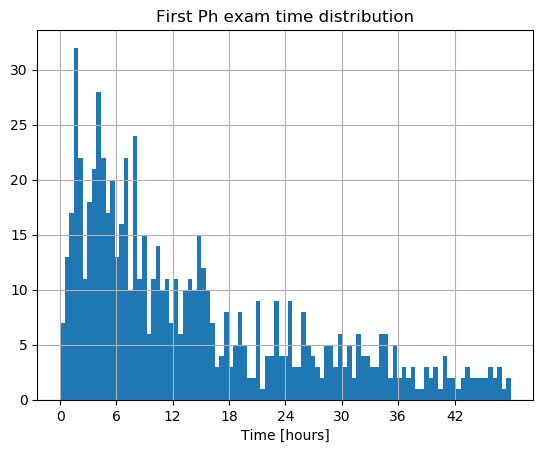

In [90]:
# CRRT

crrt_idx = [
    1014000500,2014000500,3014000500,
    4014000500,5014000500,6014000500,
]

crrt = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/observed_categoric/observed_categoric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(crrt_idx)]
    tot.append(ith)
    #ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').time.min()
    crrt.append(ith)
    
crrt = pd.concat(crrt)

#ph.to_csv('./tmp/tmp_table.csv')
#ph = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First CRRT time distribution')
plt.show()

# TODO

## Comorbidities

 - Diabetes
 - Chronic Kidney Disease
 - Hyper tension
 - Heart failure

In [99]:
# Diabetes
idx = diagnoses.referencecodename.str.extract(r'(.*[Dd]\w\wb\wt.*)').dropna().index.tolist()
diabetes_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()

,referencecode,referencecodename
5,E13.9,Diabetis mellitus
91,E11,Diabetis mellitus de tipus 2
385,E11.59,Diabetis mellitus de tipus 2 amb altres compli...
528,E11.65,Diabetis mellitus de tipus 2 amb hiperglucèmia
752,E13.10,Cetoacidosi diabètica
753,E11.01,Diabetis mellitus de tipus 2 amb hiperosmolari...
806,E13.341,Altres tipus esp. de DM amb retinopatia diabèt...
1613,249.00,Diabetis mellitus
1712,E13.9,Altres tipus especificats de diabetis mellitus...
1791,E23.2,Diabetis insípida


In [13]:
# Chronic Kidney Disease
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*renal cr\wnica.*)').dropna().index.tolist()
ckd_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()

,referencecode,referencecodename
167,N18.9,Insuficiència renal crònica
474,N18,Malaltia renal crònica
1103,N18.5,"Malaltia renal crònica, estadi 5"
1305,N18.9,Malaltia renal crònica no especificada
3598,N18.2,"Malaltia renal crònica, estadi 2 (lleu)"
3790,585.9,Insuficiència renal crònica
4866,N18.4,"Malaltia renal crònica, estadi 4 (greu)"
5203,I13.1,Cardiopatia hipertensiva i mal. renal crònica ...
5219,D63.1,Anèmia en malaltia renal crònica
6570,E13.22,Altres tipus especificats de diabetis mellitus...


In [11]:
# Hyper tension
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*hipertens.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

,referencecode,referencecodename
6,I10,Hipertensió essencial
9,I16.9,Crisi hipertensiva no especificada
10,I10,Hipertensió (primària) essencial
274,G93.5,Hipertensió intracranial
464,401.9,Hipertensió essencial
585,K76.6,Hipertensió portal
737,401.1,Hipertensió essencial benigna
1099,I15.8,Altres tipus d´hipertensió secundària
1167,I27.2,Altres tipus d´hipertensió pulmonar secundària
1547,I27.0,Hipertensió pulmonar primària


In [14]:
# Heart failure
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*insufici\wncia card\waca.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

,referencecode,referencecodename
94,I50,Insuficiència cardíaca
176,I50.9,Insuficiència cardíaca congestiva
1206,428.0,Insuficiència cardíaca congestiva
2360,402.11,Cardiopatia hipertensiva benigna a/insuficiènc...
5050,I50.2,Insuficiència cardíaca (congestiva) sistòlica
5203,I13.1,Cardiopatia hipertensiva i mal. renal crònica ...
5837,I50.9,Insuficiència cardíaca no especificada
7921,I11.9,Cardiopatia hipertensiva sense insuficiència c...
9330,I11.0,Cardiopatia hipertensiva amb insuficiència car...


In [15]:
diagnosis_codes = [
    # diabetes_codes
    # ckd_codes
    'I10','401.1','402.11','I15.8','I15.0','I11','I15','I13.1','I11.9','I15.1','I11.0','I11.0','401.9' # hyptertension
    'I50','I50.9','428.0','402.11','I50.2','I50.9','I11.0' # heart failure
] + list(diabetes_codes) + list(ckd_codes)

comorbidities = diagnoses[diagnoses.referencecode.isin(diagnosis_codes)]
comorbidities

,a_patientid,diag_type,referencecode,referencecodename
5,4000555,secondary,E13.9,Diabetis mellitus
6,4000555,secondary,I10,Hipertensió essencial
10,4000561,secondary,I10,Hipertensió (primària) essencial
19,4001427,secondary,E13.9,Diabetis mellitus
25,4001674,secondary,I10,Hipertensió essencial
...,...,...,...,...
12673,4999230,secondary,N18.9,Malaltia renal crònica no especificada
12681,4999848,secondary,E11,Diabetis mellitus de tipus 2
12686,4999848,secondary,N18.9,Insuficiència renal crònica
12690,4999872,secondary,I10,Hipertensió essencial


In [ ]:
# CRRT
idx = variables_h4.name.str.lower().str.extract(r'(.*\bfl\wx.*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
16079,4,monitored_categoric,4000003824,1.0,ACCEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16080,4,monitored_categoric,4000003824,2.0,SQUARE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16081,4,monitored_categoric,4000003824,3.0,50%DEC,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16082,4,monitored_categoric,4000003824,4.0,DECEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16083,4,monitored_categoric,4000003824,5.0,50%ACCEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16084,4,monitored_categoric,4000003824,6.0,MOD.SINE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16085,4,monitored_categoric,4000003824,7.0,SINE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16142,4,monitored_categoric,4000009541,6.0,RAMP,Tipus Corba Flux Inspiratori,PB840 Ptrn,<NA>
16143,4,monitored_categoric,4000009541,7.0,SQUARE,Tipus Corba Flux Inspiratori,PB840 Ptrn,<NA>
16217,4,monitored_numeric,4000001380,NaN,<NA>,Flux Bomba de sang,Flux Sang,Flux bomba de sang configurada


In [ ]:
vital_items = [
    4000004000, # SpO2
]

outcome_items = [
    4000001380, # Flux Sang
    4000005666, # Flux Efluent
]

monitored_predictors = []
outcomes = []

monitored_tables = tables[tables.str.match(r'monitored_numeric/monitored_numeric_4')]
for table in tqdm(monitored_tables):
    t_ith = wr.s3.read_parquet(path=f"s3://icusics-db/{table}")
    v_ith = t_ith[t_ith.a_variableid.isin(vital_items)]
    o_th = t_ith[t_ith.a_variableid.isin(outcome_items)]
    monitored_predictors.append(v_ith)
    outcomes.append(o_th)
    
monitored_predictors = pd.concat(monitored_predictors, ignore_index=True)
outcomes = pd.concat(outcomes, ignore_index=True)
outcomes

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


,a_patientid,a_variableid,time,value
0,4003958,4000001380,64497,70.0
1,4003958,4000001380,64512,70.0
2,4003958,4000001380,64527,70.0
3,4003958,4000001380,64542,70.0
4,4003958,4000001380,64572,70.0
...,...,...,...,...
267007,4995531,4000001380,470,200.0
267008,4995531,4000005666,306,3050.0
267009,4995531,4000005666,470,3050.0
267010,4997421,4000001380,1965,180.0


In [21]:
outcomes = outcomes.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')
tmp_path = './tmp/outcomes.csv'
outcomes.to_csv(tmp_path)
outcomes = pd.read_csv(tmp_path, index_col=0)
outcomes

,a_patientid,a_variableid,time,value,abbreviation
0,4003958,4000001380,64497,70.0,Flux Sang
1,4003958,4000001380,64512,70.0,Flux Sang
2,4003958,4000001380,64527,70.0,Flux Sang
3,4003958,4000001380,64542,70.0,Flux Sang
4,4003958,4000001380,64572,70.0,Flux Sang
...,...,...,...,...,...
267007,4995531,4000001380,470,200.0,Flux Sang
267008,4995531,4000005666,306,3050.0,Flux Efluent
267009,4995531,4000005666,470,3050.0,Flux Efluent
267010,4997421,4000001380,1965,180.0,Flux Sang


In [22]:
#monitored_predictors = monitored_predictors.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')
tmp_path = './tmp/vitals.csv'
#monitored_predictors.to_csv(tmp_path)
monitored_predictors = pd.read_csv(tmp_path, index_col=0)
monitored_predictors

,a_patientid,a_variableid,time,value,abbreviation
0,4000318,4000004000,8,100.0,SpO2
1,4000318,4000004000,9,100.0,SpO2
2,4000318,4000004000,11,100.0,SpO2
3,4000318,4000004000,15,100.0,SpO2
4,4000318,4000004000,19,100.0,SpO2
...,...,...,...,...,...
10175954,4999880,4000004000,980,97.0,SpO2
10175955,4999880,4000004000,982,97.0,SpO2
10175956,4999880,4000004000,986,97.0,SpO2
10175957,4999880,4000004000,992,97.0,SpO2


In [23]:
lower_bound = 12 * 60
upper_bound = 5 * 24 * 60

labs = lab_predictors.query(f"time<={lower_bound}")
vitals = monitored_predictors.query(f"time<={lower_bound}")

vitals = pd.pivot_table(
    vitals,
    index='a_patientid',
    columns='abbreviation',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs = pd.pivot_table(
    labs,
    index='a_patientid',
    columns='abbreviation',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs

# features = vitals.merge(labs, how='inner', on='a_patientid')

a_patientid      min                                      max  \
abbreviation             Albumina Hematòcrit Potassi   Urea    pH Albumina   
0                4000318      NaN       39.5     NaN    NaN  7.35      NaN   
1                4000422      3.9       34.3    4.09   83.0  7.16      3.9   
2                4000555      NaN       49.6     NaN    NaN  7.26      NaN   
3                4000561      4.5       51.3    3.97   27.0  7.38      4.5   
4                4000592      2.9       36.7    4.00   67.0  7.27      2.9   
...                  ...      ...        ...     ...    ...   ...      ...   
3820             4999651      NaN       30.5     NaN    NaN  7.42      NaN   
3821             4999848      NaN       28.5    4.63   97.0  7.32      NaN   
3822             4999872      NaN       32.0    3.25   25.0  7.44      NaN   
3823             4999880      2.9       24.1    5.61  122.0  7.34      3.1   
3824             4999885      NaN       42.1     NaN    NaN  7.40      NaN   

                                              
abbreviation Hematòcrit Potassi   Urea    pH  
0                  39.5     NaN    NaN  7.35  
1                  34.3    4.09   83.0  7.17  
2                  49.6     NaN    NaN  7.44  
3                  51.3    3.97   27.0  7.40  
4                  41.9    4.57   68.0  7.43  
...                 ...     ...    ...   ...  
3820               30.5     NaN    NaN  7.44  
3821               32.6    4.92  100.0  7.34  
3822               32.0    3.25   25.0  7.44  
3823               26.6    5.80  127.0  7.34  
3824               42.1     NaN    NaN  7.42  

[3825 rows x 11 columns]

In [24]:
vitals

,a_patientid,min,max
abbreviation,,SpO2,SpO2
0,4000318,91.3,100.0
1,4000422,91.0,99.0
2,4000555,93.3,100.0
3,4000561,92.9,100.0
4,4000592,73.9,100.0
...,...,...,...
3898,4999651,97.1,100.0
3899,4999848,89.1,100.0
3900,4999872,96.0,100.0


In [25]:
labs.columns = list(map(lambda t: t[0] + '_' + t[1], labs.columns))
vitals.columns = list(map(lambda t: t[0] + '_' + t[1], vitals.columns))

features = vitals.merge(labs, how='inner', on='a_patientid_').rename(columns={'a_patientid_': 'a_patientid'})
features

,a_patientid,min_SpO2,max_SpO2,min_Albumina,min_Hematòcrit,min_Potassi,min_Urea,min_pH,max_Albumina,max_Hematòcrit,max_Potassi,max_Urea,max_pH
0,4000318,91.3,100.0,NaN,39.5,NaN,NaN,7.35,NaN,39.5,NaN,NaN,7.35
1,4000422,91.0,99.0,3.9,34.3,4.09,83.0,7.16,3.9,34.3,4.09,83.0,7.17
2,4000555,93.3,100.0,NaN,49.6,NaN,NaN,7.26,NaN,49.6,NaN,NaN,7.44
3,4000561,92.9,100.0,4.5,51.3,3.97,27.0,7.38,4.5,51.3,3.97,27.0,7.40
4,4000592,73.9,100.0,2.9,36.7,4.00,67.0,7.27,2.9,41.9,4.57,68.0,7.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3804,4999651,97.1,100.0,NaN,30.5,NaN,NaN,7.42,NaN,30.5,NaN,NaN,7.44
3805,4999848,89.1,100.0,NaN,28.5,4.63,97.0,7.32,NaN,32.6,4.92,100.0,7.34
3806,4999872,96.0,100.0,NaN,32.0,3.25,25.0,7.44,NaN,32.0,3.25,25.0,7.44
3807,4999880,94.0,98.0,2.9,24.1,5.61,122.0,7.34,3.1,26.6,5.80,127.0,7.34


In [26]:
comorbidities['diabetis_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*diabet.*').astype(int)
comorbidities['ckd_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*renal cr.nica.*').astype(int)
comorbidities['hyperTension_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*hipertens.*').astype(int)
comorbidities['heartFailure_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*insufici\wncia card\waca.*').astype(int)

df_comorb = comorbidities.groupby('a_patientid').agg(dict.fromkeys(comorbidities.columns[-4:], 'max')).reset_index()
df_comorb

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,a_patientid,diabetis_flag,ckd_flag,hyperTension_flag,heartFailure_flag
0,4000555,1,0,1,0
1,4000561,0,0,1,0
2,4001427,1,0,0,0
3,4001674,0,0,1,0
4,4004551,1,0,1,0
...,...,...,...,...,...
880,4997421,1,1,1,0
881,4999230,0,1,1,0
882,4999848,1,1,0,0
883,4999872,0,0,1,0


In [27]:
features_v2 = features.merge(df_comorb, how='left', on='a_patientid')

for col in df_comorb.columns[1:]:
    features_v2[col] = features_v2[col].fillna(0)
    
features_v2

,a_patientid,min_SpO2,max_SpO2,min_Albumina,min_Hematòcrit,min_Potassi,min_Urea,min_pH,max_Albumina,max_Hematòcrit,max_Potassi,max_Urea,max_pH,diabetis_flag,ckd_flag,hyperTension_flag,heartFailure_flag
0,4000318,91.3,100.0,NaN,39.5,NaN,NaN,7.35,NaN,39.5,NaN,NaN,7.35,0.0,0.0,0.0,0.0
1,4000422,91.0,99.0,3.9,34.3,4.09,83.0,7.16,3.9,34.3,4.09,83.0,7.17,0.0,0.0,0.0,0.0
2,4000555,93.3,100.0,NaN,49.6,NaN,NaN,7.26,NaN,49.6,NaN,NaN,7.44,1.0,0.0,1.0,0.0
3,4000561,92.9,100.0,4.5,51.3,3.97,27.0,7.38,4.5,51.3,3.97,27.0,7.40,0.0,0.0,1.0,0.0
4,4000592,73.9,100.0,2.9,36.7,4.00,67.0,7.27,2.9,41.9,4.57,68.0,7.43,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3804,4999651,97.1,100.0,NaN,30.5,NaN,NaN,7.42,NaN,30.5,NaN,NaN,7.44,0.0,0.0,0.0,0.0
3805,4999848,89.1,100.0,NaN,28.5,4.63,97.0,7.32,NaN,32.6,4.92,100.0,7.34,1.0,1.0,0.0,0.0
3806,4999872,96.0,100.0,NaN,32.0,3.25,25.0,7.44,NaN,32.0,3.25,25.0,7.44,0.0,0.0,1.0,0.0
3807,4999880,94.0,98.0,2.9,24.1,5.61,122.0,7.34,3.1,26.6,5.80,127.0,7.34,0.0,0.0,0.0,0.0


In [28]:
target = pd.pivot_table(
    outcomes,
    index=['a_patientid','time'],
    columns=['a_variableid'],
    values='value'
).reset_index()

target = target.rename(columns={4000001380:'flux_sang', 4000005666:'flux_efluent'})
#tmp_path = './tmp/target.csv'
#target.to_csv(tmp_path)
#target = pd.read_csv(tmp_path, index_col=0)
target

a_variableid,a_patientid,time,flux_sang,flux_efluent
0,4002523,489,200.0,3002.0
1,4002523,534,200.0,3052.0
2,4002523,774,200.0,3052.0
3,4002523,834,200.0,3052.0
4,4002523,954,200.0,3052.0
...,...,...,...,...
135891,4996001,90079,100.0,202.0
135892,4996001,90094,100.0,202.0
135893,4996001,90109,100.0,202.0
135894,4996001,90124,100.0,202.0


In [33]:
target['Y'] = list(map(lambda x,y: 1 if x>=0 and y>=0 else 0, target.flux_sang.fillna(-1), target.flux_efluent.fillna(-1)))  
first_crrt = target.query('Y==1').groupby('a_patientid').time.min().reset_index()
u_target = target.merge(first_crrt, how='inner', on=['a_patientid','time'])

dataset = features_v2.merge(u_target.loc[:, ['a_patientid','time','Y']], how='left', on='a_patientid')

dataset.time = dataset.time.fillna(-1)
dataset.Y = dataset.Y.fillna(0)

#dataset_v2 = dataset.query("time<0 or time>=820")#.drop(columns=['time'])
dataset

,a_patientid,min_SpO2,max_SpO2,min_Albumina,min_Hematòcrit,min_Potassi,min_Urea,min_pH,max_Albumina,max_Hematòcrit,max_Potassi,max_Urea,max_pH,diabetis_flag,ckd_flag,hyperTension_flag,heartFailure_flag,time,Y
0,4000318,91.3,100.0,NaN,39.5,NaN,NaN,7.35,NaN,39.5,NaN,NaN,7.35,0.0,0.0,0.0,0.0,-1.0,0.0
1,4000422,91.0,99.0,3.9,34.3,4.09,83.0,7.16,3.9,34.3,4.09,83.0,7.17,0.0,0.0,0.0,0.0,-1.0,0.0
2,4000555,93.3,100.0,NaN,49.6,NaN,NaN,7.26,NaN,49.6,NaN,NaN,7.44,1.0,0.0,1.0,0.0,-1.0,0.0
3,4000561,92.9,100.0,4.5,51.3,3.97,27.0,7.38,4.5,51.3,3.97,27.0,7.40,0.0,0.0,1.0,0.0,-1.0,0.0
4,4000592,73.9,100.0,2.9,36.7,4.00,67.0,7.27,2.9,41.9,4.57,68.0,7.43,0.0,0.0,0.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3804,4999651,97.1,100.0,NaN,30.5,NaN,NaN,7.42,NaN,30.5,NaN,NaN,7.44,0.0,0.0,0.0,0.0,-1.0,0.0
3805,4999848,89.1,100.0,NaN,28.5,4.63,97.0,7.32,NaN,32.6,4.92,100.0,7.34,1.0,1.0,0.0,0.0,-1.0,0.0
3806,4999872,96.0,100.0,NaN,32.0,3.25,25.0,7.44,NaN,32.0,3.25,25.0,7.44,0.0,0.0,1.0,0.0,-1.0,0.0
3807,4999880,94.0,98.0,2.9,24.1,5.61,122.0,7.34,3.1,26.6,5.80,127.0,7.34,0.0,0.0,0.0,0.0,-1.0,0.0


In [34]:
dataset.isna().sum() / dataset.shape[0]

a_patientid          0.000000
min_SpO2             0.000000
max_SpO2             0.000000
min_Albumina         0.733001
min_Hematòcrit       0.095038
min_Potassi          0.417957
min_Urea             0.396692
min_pH               0.040431
max_Albumina         0.733001
max_Hematòcrit       0.095038
max_Potassi          0.417957
max_Urea             0.396692
max_pH               0.040431
diabetis_flag        0.000000
ckd_flag             0.000000
hyperTension_flag    0.000000
heartFailure_flag    0.000000
time                 0.000000
Y                    0.000000
dtype: float64